In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
%matplotlib inline

In [2]:
def _answer_cleaning(sequence):
    answer = [s for s in re.findall(r'-?\d+\.?\d*', sequence.replace(",", ""))]
    if len(answer) == 0:
        return -np.inf
    return float(answer[-1][:-1] if answer[-1].endswith(".") else answer[-1])

def get_answer_distribution(sampled_sequences):
    answers = [_answer_cleaning(sequence) for sequence in sampled_sequences]
    if len(answers) == 0:
        return []
    answers, answer_counts = np.unique(answers, return_counts=True)
    distribution = list(zip([str(answer) for answer in answers], [answer_count/len(sampled_sequences) for answer_count in answer_counts]))
    return sorted(distribution, key=lambda x: x[1], reverse=True)

In [3]:
MODELS_INFO = {
    'gpt2-large': {
        'recurring': 'recurring__gsm8k__gpt2-large__output.json',
        'greedy': 'greedy__gsm8k__gpt2-large__output.json',
        'baseline': 'baseline__gsm8k__gpt2-large__output.json',
        'model_size': 774_000_000,
    },
    'gemma-2b': {
        'recurring': 'recurring__gsm8k__gemma-2b__output.json',
        'greedy': 'greedy__gsm8k__gemma-2b__output.json',
        'baseline': 'baseline__gsm8k__gemma-2b__output.json',
        'model_size': 2_510_000_000,
    },
    'gemma-7b': {
        'recurring':'recurring__gsm8k__gemma-7b__output.json',
        'greedy': 'greedy__gsm8k__gemma-7b__output.json',
        'baseline': 'baseline__gsm8k__gemma-7b__output.json',
        'model_size': 8_540_000_000,
    },
}

METHODS = ['recurring', 'greedy', 'baseline']

MAJORITY_THRESHOLDS = [0.3,0.5,0.7,0.9]

RECURRING_TIMESTEPS = 3

In [4]:
def conv_float(x):
    return float(x.replace(',', '')) if len(x) > 0 else float('-inf')

def correct_with_majority_threshold(instance, correct_answer, majority_threshold=0.5, timestep=RECURRING_TIMESTEPS):
    answer_distributions = instance['answer_distribution']
    
    termination_index = timestep-1
    for ts in range(termination_index):
        if answer_distributions[ts][0][1] >= majority_threshold:
            termination_index = ts
            break
    
    return conv_float(instance["majority_vote_answers"][termination_index]) == correct_answer

def get_accuracy(model_name, method, majority_threshold=1, timestep=RECURRING_TIMESTEPS):
    if MODELS_INFO[model_name][method] is None:
        return 0
    file = os.path.join('../../results/', MODELS_INFO[model_name][method])
    output = json.load(open(file))
    
    if method == 'recurring':
        return sum(1 for inst in output if correct_with_majority_threshold(inst, conv_float(inst['ground_truth_answers']), majority_threshold, timestep)) / len(output)
    elif method == 'baseline':
        return sum(1 for inst in output if conv_float(get_answer_distribution(inst['generated_sequences'][:24])[0][0]) == conv_float(inst['ground_truth_answer'])) / len(output)
    elif method == 'greedy':
        return sum(1 for inst in output if conv_float(get_answer_distribution(inst['generated_sequences'])[0][0]) == conv_float(inst['ground_truth_answer'])) / len(output)
    raise ValueError('Invalid method')

In [5]:
plot_df = pd.DataFrame(columns=['Model', 'Method', 'Accuracy', 'Model Size'])

for model_name in MODELS_INFO:
    for method in METHODS:
        if method == 'recurring':
            majority_threshold = 0.6
            for timestep in range(1, RECURRING_TIMESTEPS+1):
                print(f'Processing {model_name} - {method} - {majority_threshold} - {timestep}')
                plot_df = pd.concat([plot_df, pd.DataFrame([{
                    'Model': model_name, 
                    'Method': f'RSC - Time Step : {timestep}', 
                    'Accuracy': get_accuracy(model_name, method, majority_threshold, timestep), 
                    'Model Size': MODELS_INFO[model_name]['model_size']
                }])], ignore_index=True)
        else:
            print(f'Processing {model_name} - {method}')
            plot_df = pd.concat([plot_df, pd.DataFrame([{
                'Model': model_name, 
                'Method': 'Self-Consistency' if method == 'baseline' else 'Greedy', 
                'Accuracy': get_accuracy(model_name, method), 
                'Model Size': MODELS_INFO[model_name]['model_size']
            }])], ignore_index=True)

Processing gpt2-large - recurring - 0.6 - 1


C:\Users\AADAM\AppData\Local\Temp\ipykernel_39560\2234807076.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_df = pd.concat([plot_df, pd.DataFrame([{


Processing gpt2-large - recurring - 0.6 - 2
Processing gpt2-large - recurring - 0.6 - 3
Processing gpt2-large - greedy
Processing gpt2-large - baseline
Processing gemma-2b - recurring - 0.6 - 1
Processing gemma-2b - recurring - 0.6 - 2
Processing gemma-2b - recurring - 0.6 - 3
Processing gemma-2b - greedy
Processing gemma-2b - baseline
Processing gemma-7b - recurring - 0.6 - 1
Processing gemma-7b - recurring - 0.6 - 2
Processing gemma-7b - recurring - 0.6 - 3
Processing gemma-7b - greedy
Processing gemma-7b - baseline


In [6]:
plot_df

,Model,Method,Accuracy,Model Size
0,gpt2-large,RSC - Time Step : 1,0.020701,774000000
1,gpt2-large,RSC - Time Step : 2,0.018198,774000000
2,gpt2-large,RSC - Time Step : 3,0.018653,774000000
3,gpt2-large,Greedy,0.013421,774000000
4,gpt2-large,Self-Consistency,0.021724,774000000
5,gemma-2b,RSC - Time Step : 1,0.223612,2510000000
6,gemma-2b,RSC - Time Step : 2,0.224636,2510000000
7,gemma-2b,RSC - Time Step : 3,0.234873,2510000000
8,gemma-2b,Greedy,0.083599,2510000000
9,gemma-2b,Self-Consistency,0.239877,2510000000


[]

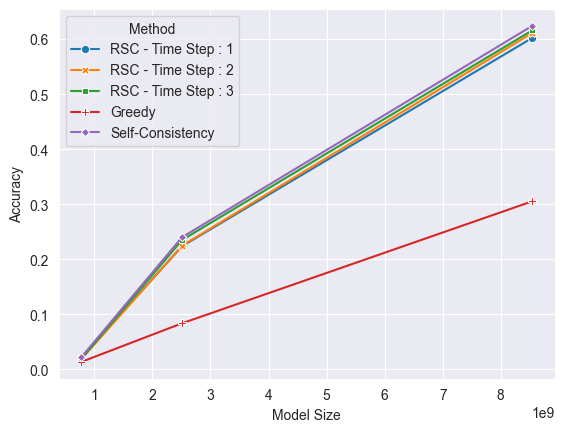

In [7]:
sns.set_style("darkgrid")
sns.lineplot(data=plot_df, x='Model Size', y='Accuracy', hue='Method', style='Method', markers=True, dashes=False)
plt.plot()